In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from pandas.plotting import lag_plot

from pandas.plotting import autocorrelation_plot

import statsmodels

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Reference

Barucca, P. and Firoozye N. (2021a). A Trend Following Strategy, Soruce code. Algorithmic Trading COMP0051, University Colleage London, delivered February 2021.

Barucca, P. and Firoozye N. (2021b). ARIMA Fit and Simulation, Soruce code. Algorithmic Trading COMP0051, University Colleage London, delivered February 2021.

Barucca, P. and Firoozye N. (2021c). Mean Reversion, Soruce code. Algorithmic Trading COMP0051, University Colleage London, delivered February 2021.

Barucca, P. and Firoozye N. (2021d). VaR, Soruce code. Algorithmic Trading COMP0051, University Colleage London, delivered February 2021.

Wang S. (2020). Sharpe Ratio, Sortino Ratio and Calmar Ratio. [Online]. [Accessed 25 February 2021]. Available from: https://towardsdatascience.com/sharpe-ratio-sorino-ratio-and-calmar-ratio-252b0cddc328

# Time Series Generation

In [2]:
student_number = 20031488

np.random.seed(student_number)
np.random.normal(0, 1, 2000)

array([ 0.83992195,  0.31702002, -1.16165334, ...,  2.04981346,
       -0.19621076,  1.12934547])

In [3]:
# time series parameter
N = 2000
phi = 0.6
d = 0.025
theta = -0.4
np.random.seed(student_number)
epsilon = np.random.normal(0, 1, N)
# epsilon[0] = 0
# epsilon[1] = 0
y = np.zeros(N)
y[0] = 100
y[1] = 100

# generate time series
for t in range(2, N): #t range 0 to 2000
    y_t1 = y[t - 1]
    y_t2 = y[t - 2]
    epsilon_t = epsilon[t]
    epsilon_t1 = epsilon[t - 1]
    y[t] = (phi * (y_t1 - y_t2 - d)) + epsilon_t + (theta * epsilon_t1) + d + y_t1
    epsilon[t] = epsilon_t

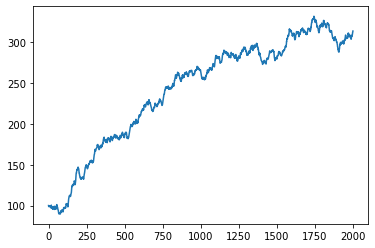

In [4]:
# plot time series data 
t = np.linspace(0, 2000, 2000)
plt.plot(t, y)

In [5]:
# split dataset
S = y.copy()
train, test = S[0:round(len(S) * 0.7)], S[round(len(S) * 0.7):]

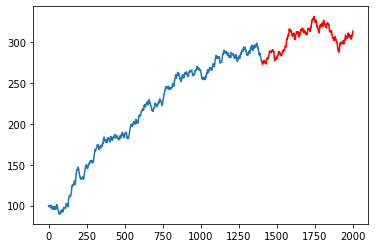

In [6]:
plt.plot(np.linspace(0, 1400, 1400), train)
plt.plot(np.linspace(1400, 2000, 600), test, color='red')
plt.show()

In [7]:
print('Training size', len(train))
print('Testing size', len(test))

Training size 1400
Testing size 600


In [8]:
# analysis the first two moments (mean and std.) of the time series
print(S.mean())
print(S.std())

241.8651106138983
66.7028543556203


In [9]:
print(train.mean())
print(train.std())

215.07437014902143
62.215760451226245


In [10]:
print(test.mean())
print(test.std())

304.3768383652777
14.716737752390324


# Functions 

## Total Value and Strategy Return

In [11]:
# Calcualte total value of strategy at each timestep
def calcualte_total_value(w, S, cash):
    return [a*b for a,b in zip(w,S)]+ cash

# Calculate strategy return at each timestep
def calcualte_strategy_return(total_value):
    total_value = pd.Series(total_value)
    total_value_shift = total_value.shift(1)
    return np.log(total_value / total_value_shift)

# Calculate overall strategy return
def calcualte_total_return(total_value):
    return (total_value[-1]-total_value[0])/total_value[0] 

# Calcualte buy and hold strategy return
def calculate_buy_and_hold_return(S):
    return (S[-1]-S[0])/S[0] 

## Performance Indicator Functions

There are three performance indicators are going to used to support the tradining strategies' results including Sharpe ratio, Value at Risk (VaR) and Calmar ratio

In [12]:
def sharpe_ratio(strategy_return):
    return strategy_return.mean() / strategy_return.std()

def annual_sharpe_ratio(strategy_return):
    return sharpe_ratio(strategy_return) * (252**0.5)

#Barucca, P. and Firoozye N (2021d)
def VaR(strategy_return, percentile):
    sorted_return = pd.Series(strategy_return)
    sorted_return = strategy_return.dropna()
    sorted_return = sorted_return.sort_values(ascending=True)   
    
    #return correspond to the percentile
    return sorted_return.quantile(percentile)

# Wang, S. (2020)
def cumulative_returns(strategy_return):
    return (strategy_return + 1.0).cumprod()

def max_drawdown(cum_returns):
    max_returns = np.fmax.accumulate(cum_returns)
    res = cum_returns / max_returns - 1
    return res.min()

def annual_returns(strategy_return):
    num_years = len(strategy_return) / 252
    cum_ret_final = (strategy_return + 1).prod().squeeze()

    return cum_ret_final ** (1 / num_years) - 1

def annual_calmar_ratio(strategy_return):

    max_dd = max_drawdown(cumulative_returns(strategy_return))
    if max_dd < 0:
        return annual_returns(strategy_return) / abs(max_dd)

    return np.nan

# Trading Strategies

# Trend Following Strategy

In [13]:
#Barucca, P. and Firoozye N (2021a)
def tf_strategy(S, time_window):
    cumsum = [0]
    #moving-average
    ma = np.zeros(np.shape(S))
    #w for volume
    w = np.zeros(np.shape(S))
    #r for return
    r = np.zeros(np.shape(S))

    #initial cash
    cash = np.zeros(np.shape(S))
    cash[0] = 10000


    for i, x in enumerate(S[:-1], 0):
        cumsum.append(cumsum[i] + x)
        #initial ma is the price x
        ma[i] = x
        if i>=time_window:
            #compute the change in cummulative sum, this is equally weighted ma
            #avg the last time window price
            moving_ave = (cumsum[i] - cumsum[i-time_window])/(time_window)
            ma[i] = moving_ave

        if ma[i] == x:
            #weight and cash is the same, i.e., no change
            w[i+1] = w[i]
            cash[i+1] = cash[i]

        #if ma is less than the spot price - indicate the buy signal of trend following
        # increase the volume of holding (you buy more)
        if ma[i] < x:
            #add extra condition to prevent short-selling
            if cash[i] >= 0:
                w[i+1] = cash[i]/x  + w[i]
                cash[i+1] = 0
            else: #no change
                w[i+1] = w[i]
                cash[i+1] = cash[i]    

        #if ma is more than the spot price - indicate the sell signal of trend following
        #sell everything - get cash and zero volume
        if ma[i] > x:
            if w[i] >= 0:
                cash[i+1] = w[i]*x + cash[i]
                w[i+1] = 0
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]    

    ma[i+1] = S[len(S)-1]
    
    t = np.linspace(0, len(S), len(S))
    plt.plot(t, cash)
    plt.xlabel('Time Step')
    plt.ylabel('Cash')
    plt.show()

    return calcualte_total_value(w, S, cash)

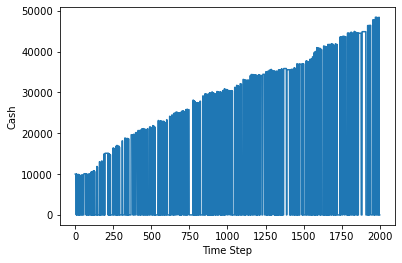

3 days total return: 3.9053911530304757


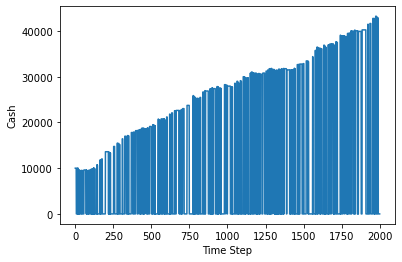

5 days total return: 3.3936855386885023


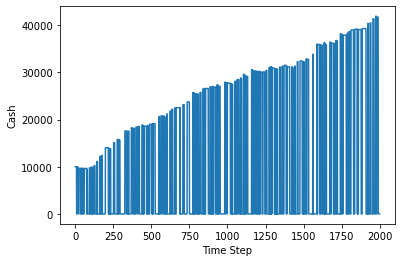

7 days total return: 3.273642485479965


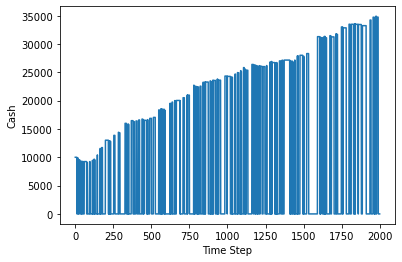

10 days total return: 2.561849530020039


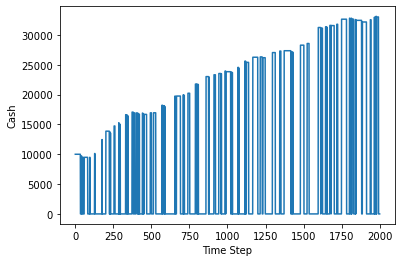

20 days total return: 2.363325227758596


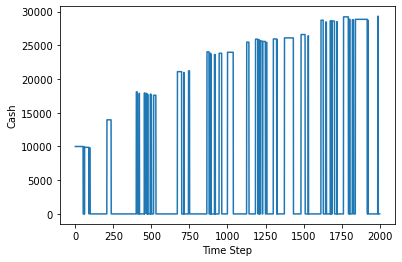

50 days total return: 2.005764463715464


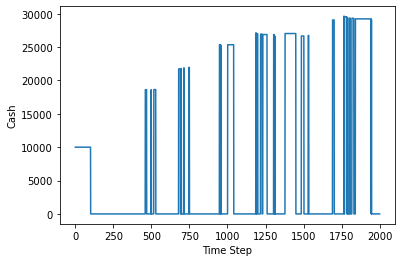

100 days total return: 2.0129821847027265


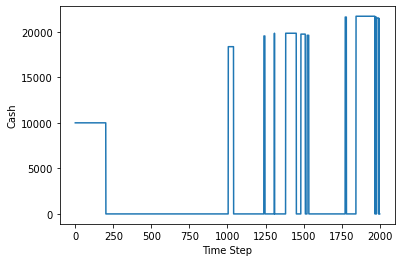

200 days total return: 1.172565476361796


In [14]:
#using the whole time series
time_window = [3, 5, 7, 10 , 20, 50, 100, 200]
tf_results = []
for i in range(0, len(time_window)):
    total_value = tf_strategy(S, time_window[i])
    strategy_return = calcualte_strategy_return(total_value)
    tf_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
    }
    tf_results.append(tf_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

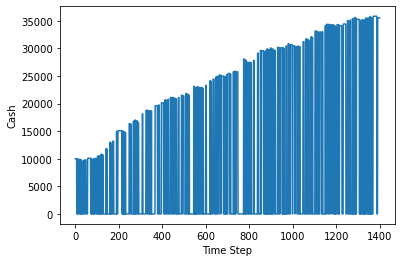

3 days total return: 2.555527466657543


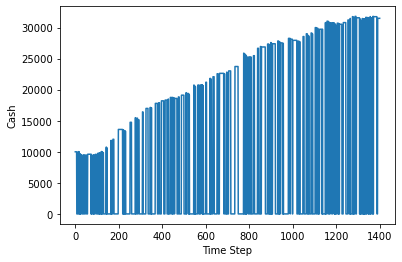

5 days total return: 2.1483218896098215


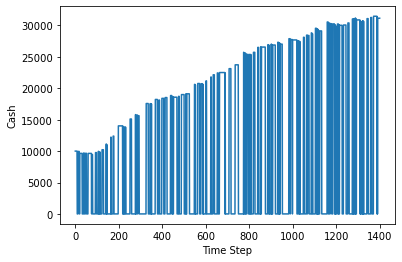

7 days total return: 2.115398282685069


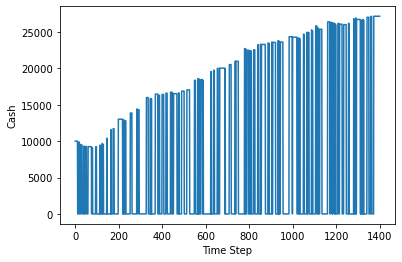

10 days total return: 1.7160546895271447


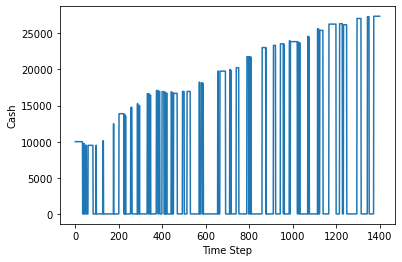

20 days total return: 1.735737330238806


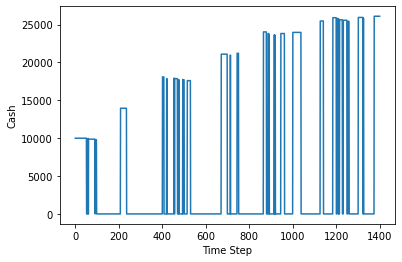

50 days total return: 1.6106174480673343


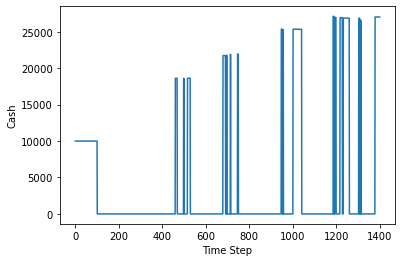

100 days total return: 1.7024779234016754


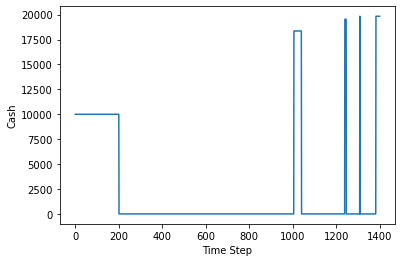

200 days total return: 0.9835509923428751


In [15]:
# use training dataset
time_window = [3, 5, 7, 10 , 20, 50, 100, 200]
tf_train_results = []
for i in range(0, len(time_window)):
    total_value = tf_strategy(train, time_window[i])
    strategy_return = calcualte_strategy_return(total_value)
    tf_train_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
    }
    tf_train_results.append(tf_train_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

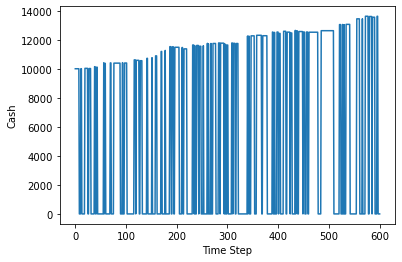

3 days total return: 0.37965216104543287


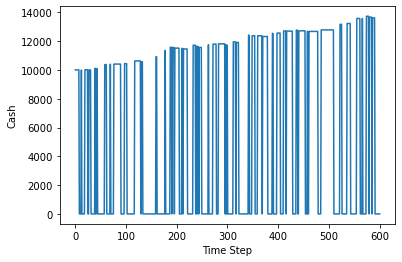

5 days total return: 0.39556426971100445


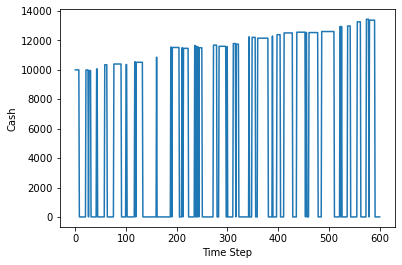

7 days total return: 0.3717804587722363


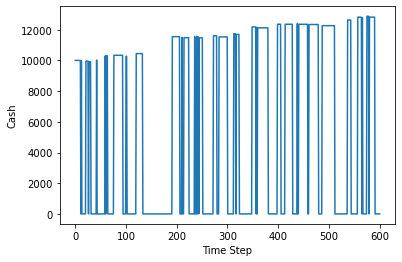

10 days total return: 0.31434859786992075


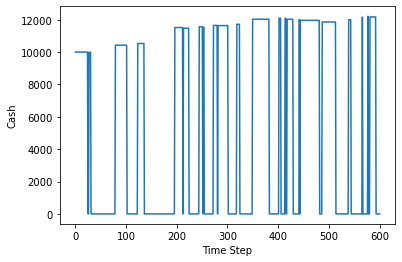

20 days total return: 0.23956733746583578


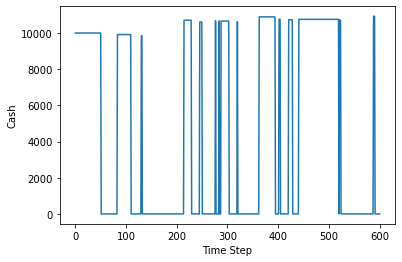

50 days total return: 0.12028479948090062


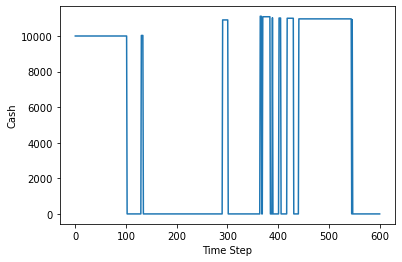

100 days total return: 0.13036151125080378


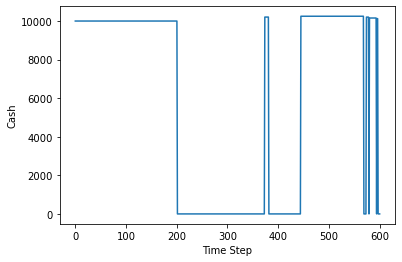

200 days total return: 0.025956705435191362


In [16]:
# use testing dataset
time_window = [3, 5, 7, 10 , 20, 50, 100, 200]
tf_test_results = []
for i in range(0, len(time_window)):
    total_value = tf_strategy(test, time_window[i])
    strategy_return = calcualte_strategy_return(total_value)
    tf_test_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
    }
    tf_test_results.append(tf_test_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

# Mean Reversion

In [17]:
#Barucca, P. and Firoozye N (2021c)
def mr_strategy(S, time_window):
    cumsum = [0]

    ma = np.zeros(np.shape(S))

    w = np.zeros(np.shape(S))
    cash = np.zeros(np.shape(S))

    cash[0] = 10000

    for i, x in enumerate(S[:-1], 0):
        cumsum.append(cumsum[i] + x)
        ma[i] = x
        if i>=time_window:
            moving_ave = (cumsum[i] - cumsum[i-time_window])/(time_window)
            ma[i] = moving_ave

        if ma[i] == x:
            w[i+1] = w[i]
            cash[i+1] = cash[i]

        if ma[i] > x: 
            if cash[i] >= 0:
                w[i+1] = cash[i]/x  + w[i] #buy
                cash[i+1] = 0
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]

        if ma[i] < x:
            if w[i] >= 0:
                cash[i+1] = w[i]*x + cash[i] #sell
                w[i+1] = 0 
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]

    ma[i+1] = S[len(S)-1]
    t = np.linspace(0, len(S), len(S))
    plt.plot(t, cash)
    plt.xlabel('Time Step')
    plt.ylabel('Cash')
    plt.show()

    return calcualte_total_value(w, S, cash)

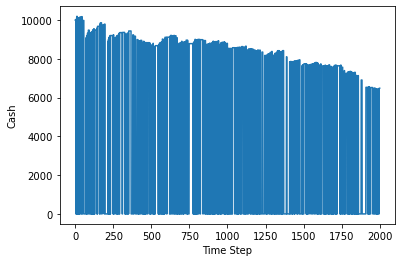

3 days total return: -0.3514164617355244


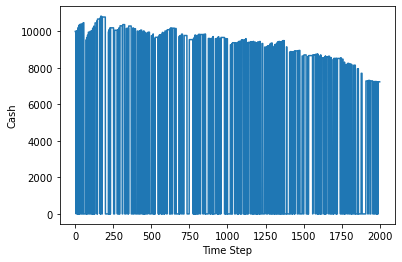

5 days total return: -0.27601014269115137


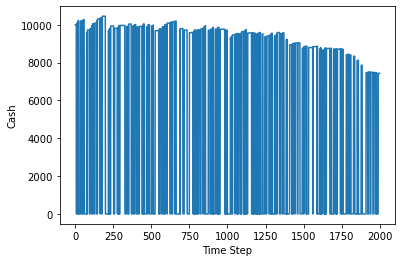

7 days total return: -0.2566735776937971


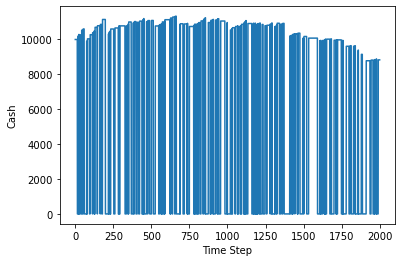

10 days total return: -0.1168614901790932


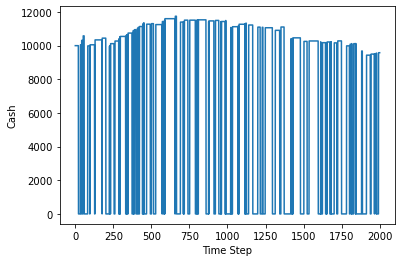

20 days total return: -0.04192462974656464


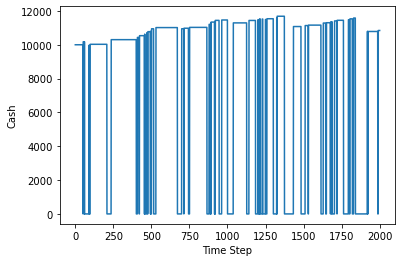

50 days total return: 0.08439584188791305


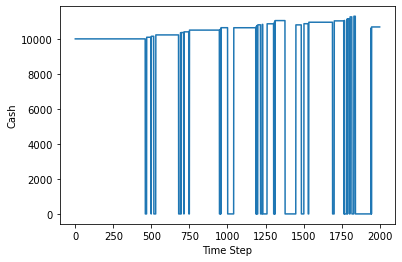

100 days total return: 0.06812189476852983


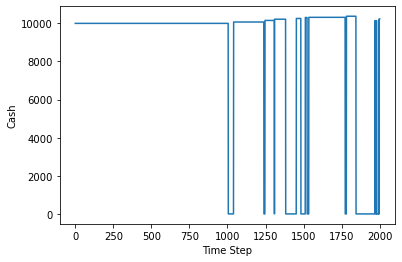

200 days total return: 0.023651739484187966


In [18]:
time_window = [3, 5, 7, 10 , 20, 50, 100, 200]
mr_results = []
for i in range(0, len(time_window)):
    total_value = mr_strategy(S, time_window[i])
    strategy_return = calcualte_strategy_return(total_value)
    mr_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
    }
    mr_results.append(mr_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

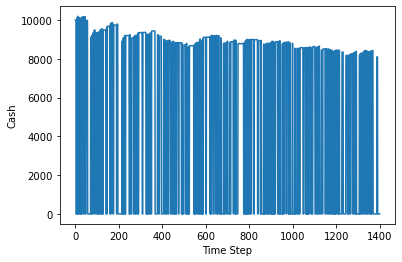

3 days total return: -0.20845339962534862


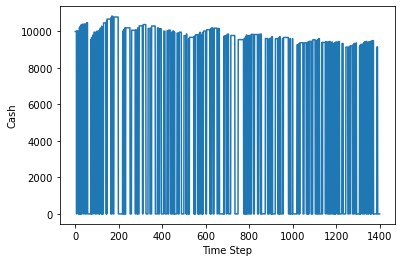

5 days total return: -0.1062351214117336


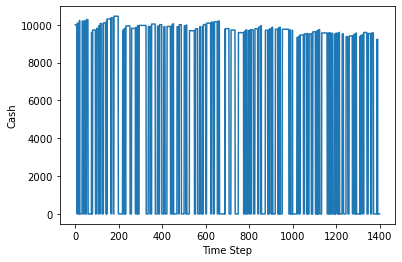

7 days total return: -0.09800289572791061


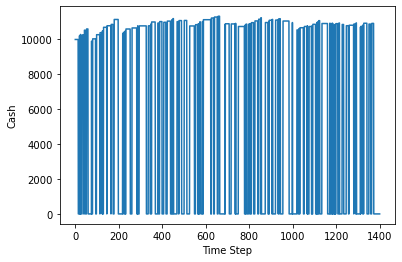

10 days total return: 0.024487920180186848


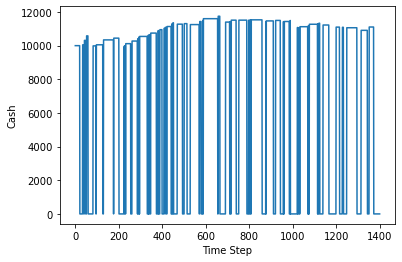

20 days total return: 0.04192175189587197


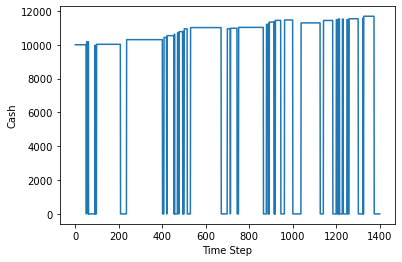

50 days total return: 0.10443589662104823


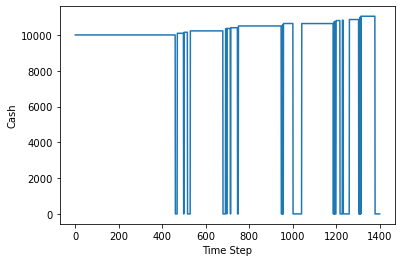

100 days total return: 0.05340696900626936


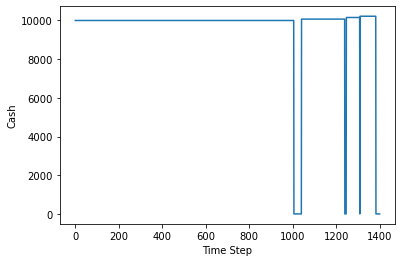

200 days total return: -0.008203220029342446


In [19]:
time_window = [3, 5, 7, 10 , 20, 50, 100, 200]
mr_train_results = []
for i in range(0, len(time_window)):
    total_value = mr_strategy(train, time_window[i])
    strategy_return = calcualte_strategy_return(total_value)
    mr_train_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
    }
    mr_train_results.append(mr_train_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

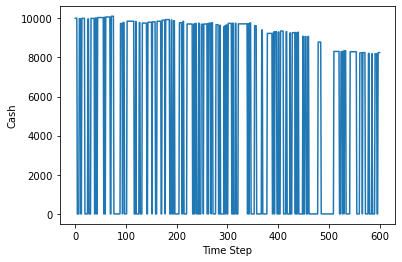

3 days total return: -0.17566057003783753


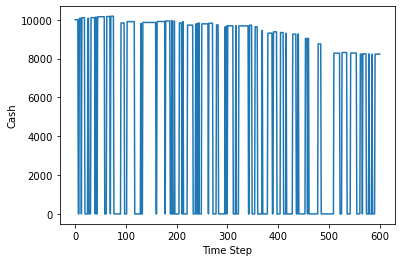

5 days total return: -0.1771650855515185


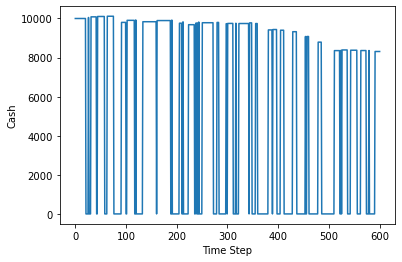

7 days total return: -0.16889149236837855


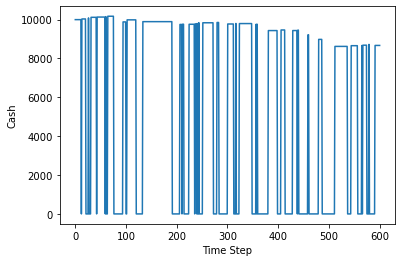

10 days total return: -0.13278705084212014


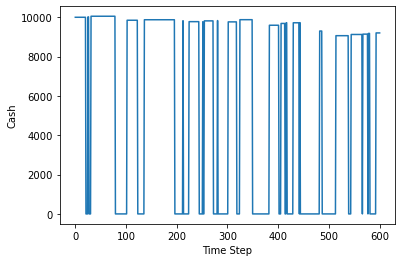

20 days total return: -0.07961494831486034


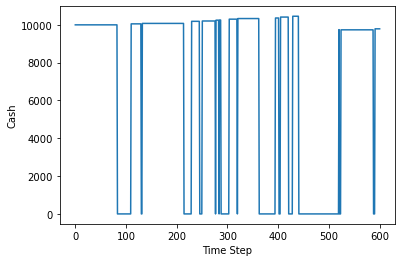

50 days total return: -0.021046297964353835


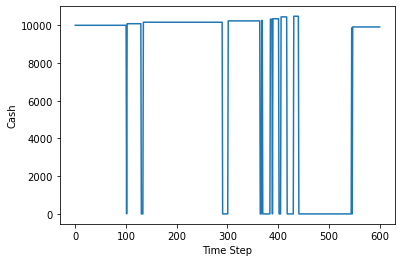

100 days total return: -0.008811434434169133


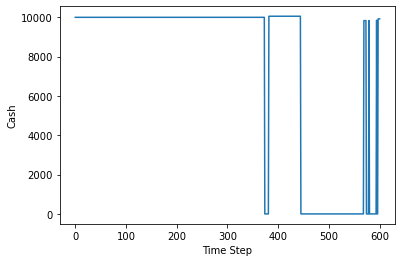

200 days total return: -0.00788138422435568


In [20]:
time_window = [3, 5, 7, 10 , 20, 50, 100, 200]
mr_test_results = []
for i in range(0, len(time_window)):
    total_value = mr_strategy(test, time_window[i])
    strategy_return = calcualte_strategy_return(total_value)
    mr_test_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
    }
    mr_test_results.append(mr_test_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

## ARIMA 

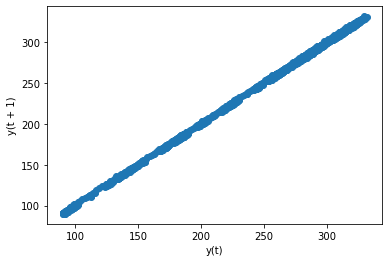

In [21]:
lag_plot(pd.Series(S))
plt.show()

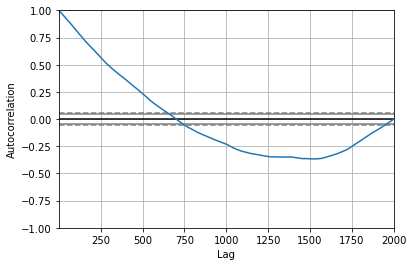

In [22]:
autocorrelation_plot(pd.Series(S))
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1398
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1955.213
Method:                       css-mle   S.D. of innovations              0.980
Date:                Wed, 03 Mar 2021   AIC                           3918.426
Time:                        09:04:41   BIC                           3939.397
Sample:                             1   HQIC                          3926.266
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1263      0.041      3.108      0.002       0.047       0.206
ar.L1.D.y      0.6458      0.075      8.588      0.000       0.498       0.793
ma.L1.D.y     -0.4505      0.088     -5.117      0.0

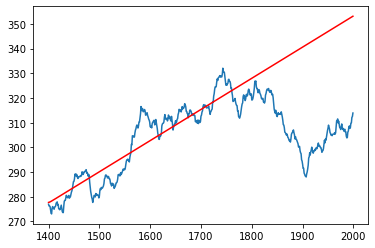

In [23]:
#Barucca, P. and Firoozye N (2021b)

from statsmodels.tsa.arima_model import ARIMA as arima
from sklearn.metrics import mean_squared_error

# split dataset
X = pd.Series(S)
train, test = X[1:len(X)-600], X[len(X)-600:]
# train autoregression
model_1 = arima(endog=train, order=(1, 1, 1))  
model_train_fit = model_1.fit() # stationarity can be checked here. We don't
print(model_train_fit.summary())

# # make predictions from start of sample onwards. 
predictions = model_train_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
pred = np.nan * X
pred = np.cumsum(predictions)
# plot results
plt.plot(test)
plt.plot(pred + X[len(train)], color='red')
plt.show()

In [24]:
#dynamic prediction

dyn = pd.Series(np.zeros(len(X),) * np.nan, index=X.index)

/Users/TinyJiew/opt/anaconda3/envs/learnPython/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


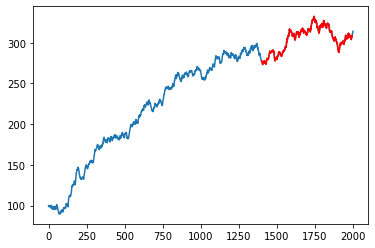

In [25]:
for t in range(len(X)-600,len(X)-5):
    model = arima(X[:t], order = (1,0,1))
    model_fit = model.fit()
    model_forecast = model_fit.forecast()[0]
    #     dyna = model_fit.predict(start=i, end=i+1, exog=test.loc[0:t+1], dynamic=False)
    dyn.loc[t] = model_forecast
plt.plot(X)
plt.plot(dyn, color='red')
plt.show()

In [26]:
pd.concat([dyn - X.shift(), X - X.shift()], axis=1).corr()

,0,1
0,1.000000,0.206923
1,0.206923,1.000000


In [27]:
a = model_train_fit.params
a

const        0.126266
ar.L1.D.y    0.645787
ma.L1.D.y   -0.450504
dtype: float64

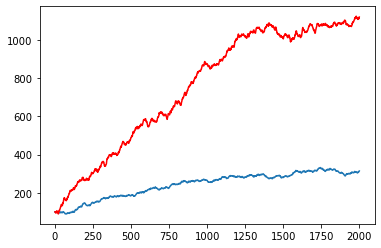

In [28]:
# Let's simulate it and see if we can 'trade' it
eps= np.random.randn(len(X)) * 2.583
dY = np.nan * X
Y = np.nan * X
# Simulate first differences since ARIMA(2,1,2) then cumsum to get prices
dY[0] = 0.0
dY[1] = 0.0
Y[0] = X[0]
Y[1] = X[1]
for t in range(2,len(X)):     
    dY[t] = a['const'] + a['ar.L1.D.y'] * dY[t-1] + \
         eps[t] + a['ma.L1.D.y'] * eps[t-1]
    Y[t] = Y[t-1] + dY[t]
plt.plot(X)
plt.plot(Y, color='red')
plt.show()

In [29]:
def arima_mr_strategy(S, time_window, Y):
    #capture the moving average
    cumsum = [0]

    #moving-average of prediction
    ma = np.zeros(np.shape(S))

    #w for volume
    w = np.zeros(np.shape(S))
    cash = np.zeros(np.shape(S))
    #r for return
    r = np.zeros(np.shape(S))
    
    Z = np.zeros(np.shape(S))

    #initial cash
    cash[0] = 10000


    for i, x in enumerate(S[:-1], 0):
        cumsum.append(cumsum[i] + x)
        #initial ma is the price x
        ma[i] = x
        if i>=time_window:
            moving_ave = (cumsum[i] - (Y[i] - Y[i-time_window]/(time_window)))
            ma[i] = moving_ave

        if ma[i] == x:
            w[i+1] = w[i]
            cash[i+1] = cash[i]

        if ma[i] > x:
            if cash[i] >= 0:
                w[i+1] = cash[i]/x  + w[i]
                cash[i+1] = 0
            else: #no change
                w[i+1] = w[i]
                cash[i+1] = cash[i]    

        if ma[i] < x:
            if w[i] >= 0:
                cash[i+1] = w[i]*x + cash[i]
                w[i+1] = 0
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]    

    ma[i+1] = S[len(S)-1]
    t = np.linspace(0, len(S), len(S))
    plt.plot(t, cash)
    plt.xlabel('Time Step')
    plt.ylabel('Cash')
    plt.show()
    return calcualte_total_value(w, S, cash)

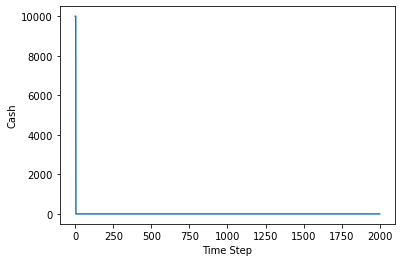

3 days total return: 2.181555950603762


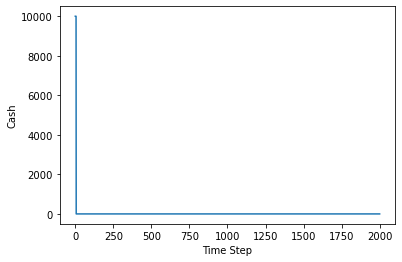

5 days total return: 2.1809837662150393


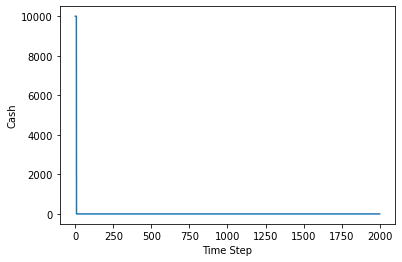

7 days total return: 2.176711378947607


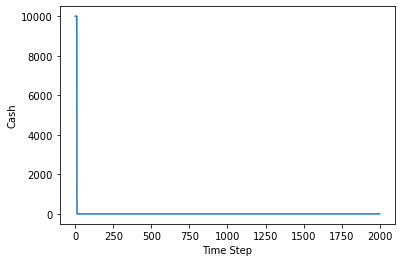

10 days total return: 2.145606486148195


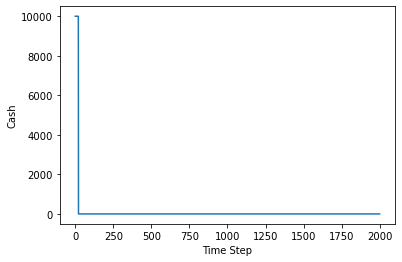

20 days total return: 2.222319062867533


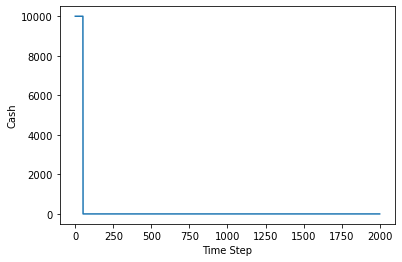

50 days total return: 2.2594384861475016


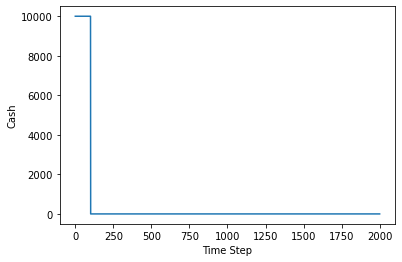

100 days total return: 2.2182322400284993


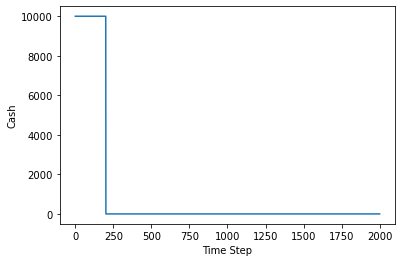

200 days total return: 1.2239504290210461


In [30]:
#using the whole time series
time_window = [3, 5, 7, 10, 20, 50, 100, 200]
arima_mr_results = []
for i in range(0, len(time_window)):
    total_value = arima_mr_strategy(S, time_window[i], Y)
    strategy_return = calcualte_strategy_return(total_value)
    arima_mr_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
    }
    arima_mr_results.append(arima_mr_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

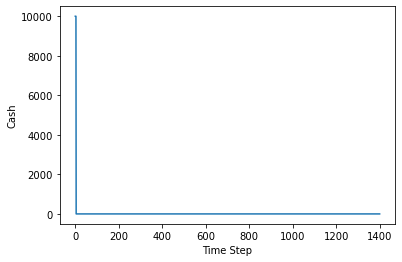

3 days total return: 1.8106116459856478


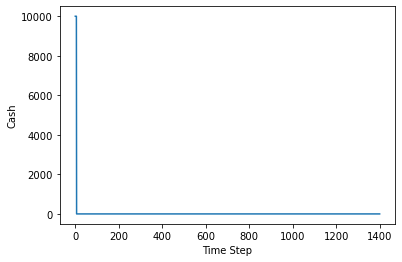

5 days total return: 1.8053408802612623


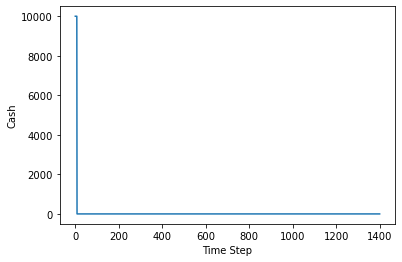

7 days total return: 1.7852439672266631


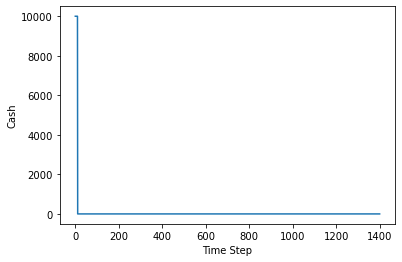

10 days total return: 1.7936891448536014


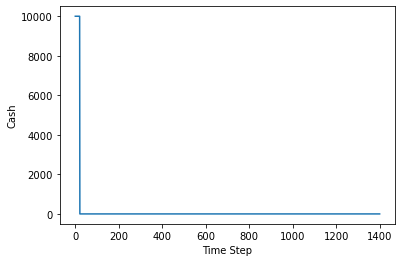

20 days total return: 1.8724961131489024


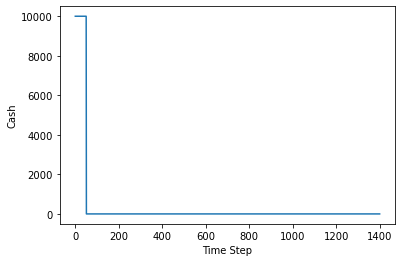

50 days total return: 1.8339538026233495


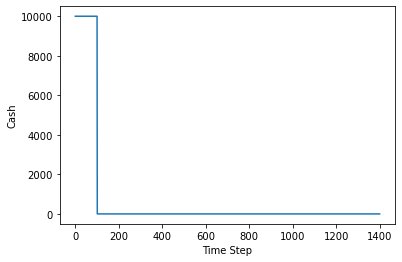

100 days total return: 1.8791951328022927


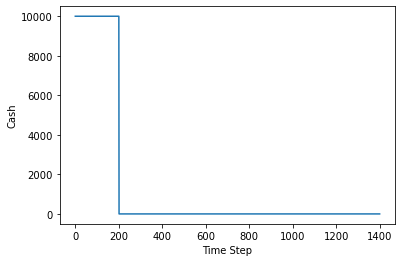

200 days total return: 0.9884330651754306


In [31]:
arima_mr_train_results = []
for i in range(0, len(time_window)):
    total_value = arima_mr_strategy(train, time_window[i], Y)
    strategy_return = calcualte_strategy_return(total_value)
    arima_mr_train_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
    }
    arima_mr_train_results.append(arima_mr_train_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

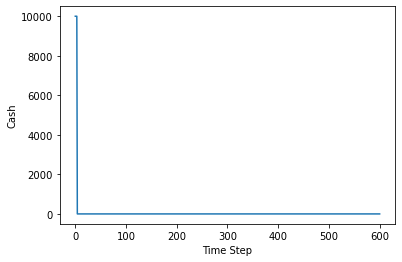

3 days total return: 0.1373016759822589


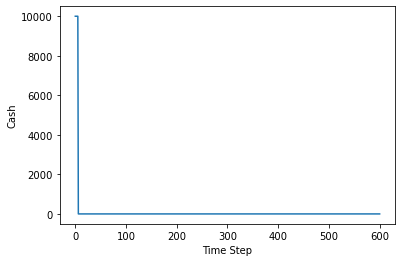

5 days total return: 0.14831900647501225


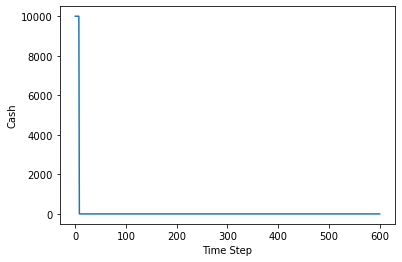

7 days total return: 0.14009840988841515


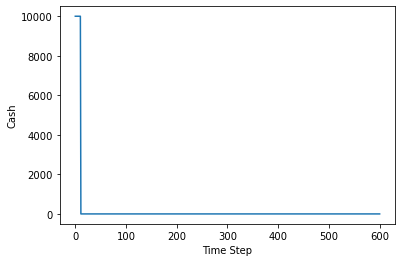

10 days total return: 0.1398201237802974


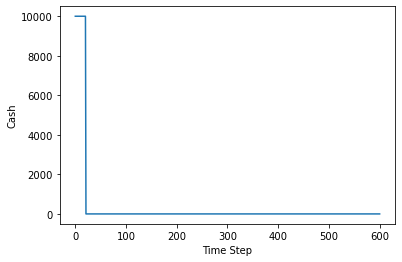

20 days total return: 0.1408792479607051


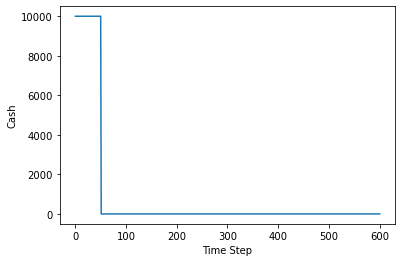

50 days total return: 0.09670695178608894


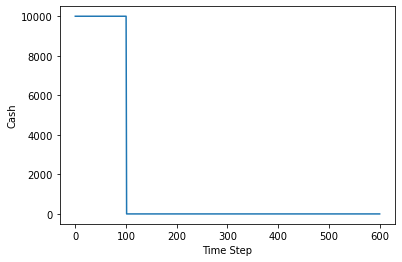

100 days total return: 0.12040140490750854


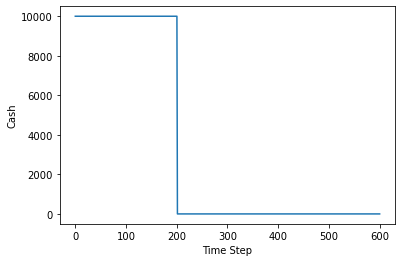

200 days total return: 0.017870746442102427


In [32]:
arima_mr_test_results = []
for i in range(0, len(time_window)):
    total_value = arima_mr_strategy(np.array(test), time_window[i], Y)
    strategy_return = calcualte_strategy_return(total_value)
    arima_mr_test_dict = {
      "time_window": time_window[i],
      "total_value": total_value,
      "total_return": calcualte_total_return(total_value),
      "strategy_return": strategy_return,
      "sharpe_ratio": sharpe_ratio(strategy_return),
      "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
      "VaR": VaR(strategy_return, 0.05),
      "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
    }
    arima_mr_test_results.append(arima_mr_test_dict)
    print(time_window[i] , 'days total return:', calcualte_total_return(total_value))

## Buy and Hold

In [33]:
cash = np.zeros(np.shape(S))
cash[0] = 10000
total_value = (cash[0]*S/S[0])
strategy_return = calcualte_strategy_return(total_value)
bh_result_dict = {
    "total_value": total_value,
    "total_return": calcualte_total_return(total_value),
    "strategy_return": strategy_return,
    "sharpe_ratio": sharpe_ratio(strategy_return),
    "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
    "VaR": VaR(strategy_return, 0.05),
    "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
}
print('buy and hold total return:', calcualte_total_return(total_value))

buy and hold total return: 2.1389941978469973


In [34]:
train = np.array(train)
total_value = (cash[0]*train/train[0])
strategy_return = calcualte_strategy_return(total_value)
bh_train_result_dict = {
    "total_value": total_value,
    "total_return": calcualte_total_return(total_value),
    "strategy_return": strategy_return,
    "sharpe_ratio": sharpe_ratio(strategy_return),
    "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
    "VaR": VaR(strategy_return, 0.05),
    "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
}
print('buy and hold (train)total return:', calcualte_total_return(total_value))

buy and hold (train)total return: 1.776716070200466


In [35]:
test = np.array(test)
total_value = cash[0]*test/test[0]
strategy_return = calcualte_strategy_return(total_value)
bh_test_result_dict = {
    "total_value": total_value,
    "total_return": calcualte_total_return(total_value),
    "strategy_return": strategy_return,
    "sharpe_ratio": sharpe_ratio(strategy_return),
    "annual_sharpe_ratio": annual_sharpe_ratio(strategy_return),
    "VaR": VaR(strategy_return, 0.05),
    "annual_calmar_ratio": annual_calmar_ratio(strategy_return)
        
}
print('buy and hold (test)total return:', calcualte_total_return(total_value))

buy and hold (test)total return: 0.13340997679847916


# Overall Results

In [36]:
print('buy and hold (test)total return:', bh_test_result_dict.get("total_return"))
print('buy and hold (test)SR:', bh_test_result_dict.get("sharpe_ratio"))
print('buy and hold (test)annual SR:', bh_test_result_dict.get("annual_sharpe_ratio"))
print('buy and hold (test)VaR:', bh_test_result_dict.get("VaR"))
print('buy and hold (test)annual calmar ratio:', bh_test_result_dict.get("annual_calmar_ratio"))

buy and hold (test)total return: 0.13340997679847916
buy and hold (test)SR: 0.06085434848899981
buy and hold (test)annual SR: 0.9660328337925165
buy and hold (test)VaR: -0.005430990759008244
buy and hold (test)annual calmar ratio: 0.39274144743927625


In [37]:
df_tf_train_results = pd.DataFrame(tf_train_results)
df_tf_train_results.head()

,time_window,total_value,total_return,strategy_return,sharpe_ratio,annual_sharpe_ratio,VaR,annual_calmar_ratio
0,3,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",2.555527,0 NaN 1 0.0 2 0.0 3 0....,0.205674,3.264972,-0.005460,5.571046
1,5,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",2.148322,0 NaN 1 0.0 2 0.0 3 0....,0.190039,3.016782,-0.005460,3.313987
2,7,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",2.115398,0 NaN 1 0.0 2 0.0 3 0....,0.187434,2.975425,-0.005608,3.968633
3,10,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",1.716055,0 NaN 1 0.0 2 0.0 3 0....,0.160213,2.543307,-0.006155,2.062862
4,20,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",1.735737,0 NaN 1 0.0 2 0.0 3 0....,0.155352,2.466133,-0.006487,3.000259


In [38]:
df_tf_test_results = pd.DataFrame(tf_test_results)
df_tf_test_results.head(10)

,time_window,total_value,total_return,strategy_return,sharpe_ratio,annual_sharpe_ratio,VaR,annual_calmar_ratio
0,3,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.379652,0 NaN 1 0.000000 2 0.00000...,0.216603,3.438463,-0.003504,8.737282
1,5,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.395564,0 NaN 1 0.000000 2 0.00000...,0.224094,3.557377,-0.003497,7.814263
2,7,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.371780,0 NaN 1 0.000000 2 0.00000...,0.211232,3.353203,-0.003504,6.649548
3,10,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.314349,0 NaN 1 0.000000 2 0.00000...,0.182525,2.897497,-0.003638,5.567740
4,20,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.239567,0 NaN 1 0.000000 2 0.00000...,0.147495,2.341403,-0.003638,2.808157
5,50,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.120285,0 NaN 1 0.000000 2 0.00000...,0.073966,1.174182,-0.004189,1.001372
6,100,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.130362,0 NaN 1 0.000000 2 0.00000...,0.078371,1.244094,-0.004494,0.886763
7,200,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.025957,0 NaN 1 0.000000 2 0.00000...,0.019267,0.305858,-0.004193,0.169090


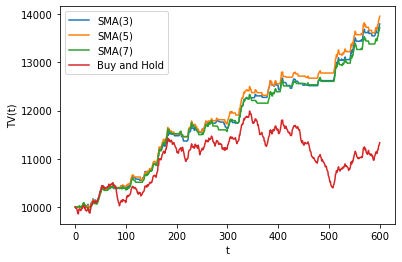

In [39]:
t = np.linspace(0, len(test), len(test))
plt.plot(t, tf_test_results[0].get('total_value'), label='SMA(3)')
plt.plot(t, tf_test_results[1].get('total_value'), label='SMA(5)')
plt.plot(t, tf_test_results[2].get('total_value'), label='SMA(7)')
plt.plot(t, bh_test_result_dict.get('total_value'), label='Buy and Hold')
plt.xlabel('t')
plt.ylabel('TV(t)')
plt.legend()
plt.show()

In [40]:
df_mr_train_results = pd.DataFrame(mr_train_results)
df_mr_train_results.head(100)

,time_window,total_value,total_return,strategy_return,sharpe_ratio,annual_sharpe_ratio,VaR,annual_calmar_ratio
0,3,"[10000.0, 10000.0, 10000.0, 10000.0, 10013.356...",-0.208453,0 NaN 1 0.000000 2 0.00...,-0.048063,-0.762969,-0.006335,-0.185027
1,5,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.106235,0 NaN 1 0.000000 2 0.00...,-0.022195,-0.352331,-0.006239,-0.120435
2,7,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.098003,0 NaN 1 0.000000 2 0.00...,-0.020514,-0.325655,-0.006181,-0.140973
3,10,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.024488,0 NaN 1 0.000000 2 0.00...,0.005024,0.079758,-0.005851,0.029244
4,20,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.041922,0 NaN 1 0.000000 2 0.00...,0.009678,0.153639,-0.005002,0.053931
5,50,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.104436,0 NaN 1 0.000000 2 0.00...,0.027074,0.429784,-0.003773,0.231205
6,100,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.053407,0 NaN 1 0.000000 2 0.00...,0.027082,0.429911,-0.000315,0.192209
7,200,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.008203,0 NaN 1 0.000000 2 0.00...,-0.007527,-0.119494,0.000000,-0.048686


In [41]:
df_mr_test_results = pd.DataFrame(mr_test_results)
df_mr_test_results.head(10)

,time_window,total_value,total_return,strategy_return,sharpe_ratio,annual_sharpe_ratio,VaR,annual_calmar_ratio
0,3,"[10000.0, 10000.0, 10000.0, 10000.0, 9956.5749...",-0.175661,0 NaN 1 0.000000 2 0.00000...,-0.140234,-2.226149,-0.005275,-0.397671
1,5,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.177165,0 NaN 1 0.0 2 0.0 3 0.0 4 ...,-0.143109,-2.271792,-0.005161,-0.396438
2,7,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.168891,0 NaN 1 0.0 2 0.0 3 0.0 4 ...,-0.137830,-2.187978,-0.004959,-0.403913
3,10,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.132787,0 NaN 1 0.0 2 0.0 3 0.0 4 ...,-0.105251,-1.670802,-0.004799,-0.358081
4,20,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.079615,0 NaN 1 0.0 2 0.0 3 0.0 4 ...,-0.059610,-0.946283,-0.004587,-0.279020
5,50,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.021046,0 NaN 1 0.0 2 0.0 3 0.0 4 ...,-0.017217,-0.273305,-0.003875,-0.089267
6,100,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.008811,0 NaN 1 0.0 2 0.0 3 0.0 4 ...,-0.008368,-0.132838,-0.003044,-0.038841
7,200,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",-0.007881,0 NaN 1 0.000000 2 0.00000...,-0.007627,-0.121075,-0.002881,-0.039279


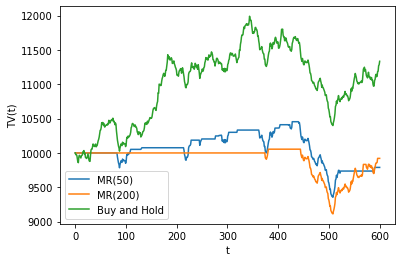

In [42]:
t = np.linspace(0, len(test), len(test))
plt.plot(t, mr_test_results[5].get('total_value'), label='MR(50)')
plt.plot(t, mr_test_results[7].get('total_value'), label='MR(200)')
plt.plot(t, bh_test_result_dict.get('total_value'), label='Buy and Hold')
plt.xlabel('t')
plt.ylabel('TV(t)')
plt.legend()
plt.show()

In [43]:
df_arima_mr_train_results = pd.DataFrame(arima_mr_train_results)
df_arima_mr_train_results.head(10)

,time_window,total_value,total_return,strategy_return,sharpe_ratio,annual_sharpe_ratio,VaR,annual_calmar_ratio
0,3,"[10000.0, 10000.0, 10000.0, 10000.0, 9988.4575...",1.810612,0 NaN 1 0.000000 2 0.00...,0.130985,2.079323,-0.007844,1.754878
1,5,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",1.805341,0 NaN 1 0.000000 2 0.00...,0.130759,2.075727,-0.007844,1.751324
2,7,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",1.785244,0 NaN 1 0.000000 2 0.00...,0.129951,2.062909,-0.007844,1.737762
3,10,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",1.793689,0 NaN 1 0.000000 2 0.00...,0.130521,2.071953,-0.007844,1.743619
4,20,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",1.872496,0 NaN 1 0.000000 2 0.00...,0.136513,2.167072,-0.007718,1.797983
5,50,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",1.833954,0 NaN 1 0.000000 2 0.00...,0.140185,2.225366,-0.007469,1.775364
6,100,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",1.879195,0 NaN 1 0.000000 2 0.00...,0.151484,2.404742,-0.007004,2.021930
7,200,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.988433,0 NaN 1 0.000000 2 0.00...,0.116479,1.849045,-0.006521,1.814223


In [44]:
df_arima_mr_test_results = pd.DataFrame(arima_mr_test_results)
df_arima_mr_test_results.head(10)

,time_window,total_value,total_return,strategy_return,sharpe_ratio,annual_sharpe_ratio,VaR,annual_calmar_ratio
0,3,"[10000.0, 10000.0, 10000.0, 10000.0, 9956.5749...",0.137302,0 NaN 1 0.000000 2 0.00000...,0.062558,0.993079,-0.005431,0.404109
1,5,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.148319,0 NaN 1 0.000000 2 0.00000...,0.067491,1.071391,-0.005431,0.436214
2,7,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.140098,0 NaN 1 0.000000 2 0.00000...,0.064298,1.020704,-0.005431,0.412452
3,10,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.139820,0 NaN 1 0.000000 2 0.00000...,0.064219,1.019438,-0.005431,0.411656
4,20,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.140879,0 NaN 1 0.000000 2 0.00000...,0.065148,1.034192,-0.005333,0.414905
5,50,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.096707,0 NaN 1 0.000000 2 0.00000...,0.046808,0.743054,-0.005333,0.285471
6,100,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.120401,0 NaN 1 0.000000 2 0.00000...,0.060207,0.955757,-0.005274,0.356463
7,200,"[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...",0.017871,0 NaN 1 0.000000 2 0.00000...,0.010500,0.166688,-0.004957,0.048416


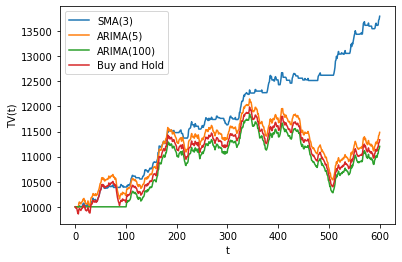

In [45]:
t = np.linspace(0, len(test), len(test))
plt.plot(t, tf_test_results[0].get('total_value'), label='SMA(3)')
plt.plot(t, arima_mr_test_results[1].get('total_value'), label='ARIMA(5)')
plt.plot(t, arima_mr_test_results[6].get('total_value'), label='ARIMA(100)')
plt.plot(t, bh_test_result_dict.get('total_value'), label='Buy and Hold')
plt.xlabel('t')
plt.ylabel('TV(t)')
plt.legend()
plt.show()

# Statistical Tests

In [46]:
from scipy.stats import t

def calculate_p_value(strategy_results):
    strategy_return = strategy_results.get('strategy_return')
    sharpe_ratio = strategy_results.get('sharpe_ratio')
    data_size = len(strategy_return)
    return t.cdf(strategy_return.mean(), sharpe_ratio * np.sqrt(data_size), data_size - 1)

In [47]:
p_value_3 = calculate_p_value(tf_test_results[0])
print(p_value_3, ' <0.05?', p_value_3 < 0.05)

2.5392283190883032e-14  <0.05? True


In [48]:
p_value_5 = calculate_p_value(tf_test_results[1])
print(p_value_5, ' <0.05?', p_value_5 < 0.05)

9.894171983146038e-15  <0.05? True


In [49]:
p_value_7 = calculate_p_value(tf_test_results[2])
print(p_value_7, ' <0.05?', p_value_7 < 0.05)

5.002121875976317e-14  <0.05? True


In [50]:
# multiple all of them by number of tests, i.e., N = 3
# follows Bonfeeroni's method
print(p_value_3 * 3, ' <0.05?', p_value_3 * 3 < 0.05) 
print(p_value_5 * 3, ' <0.05?', p_value_5 * 3 < 0.05) 
print(p_value_7 * 3, ' <0.05?', p_value_7 * 3 < 0.05) 

7.617684957264909e-14  <0.05? True
2.968251594943811e-14  <0.05? True
1.5006365627928952e-13  <0.05? True


In [51]:
def calculate_annual_p_value(strategy_results):
    strategy_return = strategy_results.get('strategy_return')
    sharpe_ratio = strategy_results.get('annual_sharpe_ratio')
    data_size = len(strategy_return)
    return t.cdf(strategy_return.mean(), sharpe_ratio * np.sqrt(data_size), data_size - 1)

In [52]:
annual_p_value_3 = calculate_annual_p_value(tf_test_results[0])
print(annual_p_value_3, ' <0.05?', annual_p_value_3 < 0.05)

6.157268578170768e-155  <0.05? True


In [53]:
annual_p_value_5 = calculate_annual_p_value(tf_test_results[1])
print(annual_p_value_5, ' <0.05?', annual_p_value_5 < 0.05)

1.3778138040168452e-159  <0.05? True


In [54]:
annual_p_value_7 = calculate_annual_p_value(tf_test_results[2])
print(annual_p_value_7, ' <0.05?', annual_p_value_7 < 0.05)

1.3711110441662615e-151  <0.05? True


In [55]:
# multiple all of them by number of tests, i.e., N = 3
# follows Bonfeeroni's method
print(annual_p_value_3 * 3, ' <0.05?', annual_p_value_3 * 3 < 0.05) 
print(annual_p_value_5 * 3, ' <0.05?', annual_p_value_5 * 3 < 0.05) 
print(annual_p_value_7 * 3, ' <0.05?', annual_p_value_7 * 3 < 0.05) 

1.8471805734512302e-154  <0.05? True
4.1334414120505353e-159  <0.05? True
4.113333132498785e-151  <0.05? True
